# Final Project Report
## Josh Gen, jdg9vr

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from gensim.models import Word2Vec

# Introduction

This project is an extension of my Capstone Project, in which we use text data scraped from company websites in the magnetics industry to determine similarity to a target company. This is a small subset of our much larger scraped data for Capstone Project. For my corpus, each document is a company, and these documents are subsetted by the actual link the text was scraped from (different links for different pages of the same website). These links can be further subsetted by sentences. The data's OHCO is only company id and link number. The data is anonymized as well.

Due to the anonymization, it is difficult to discover true trends from the underlying data, but I hope to analyze trends across the dataset as a whole. For example, which of the companies are most and least related? What are the differing contents across these websites? What emotions do the creators of the websites attempt to evoke with the websites?

# Source Data

### Provenance

The data for this project was scraped for my Capstone Project. The data is created from a website crawler method where a crawler crawls through a full website, scraping all the links and text from a full website. The goal of this method is to scrape the text from every link with the same domain as the home website. The scraping was originally performed for about 8,500 companies and was about 22 GB large. Unfortunately, this large dataset is stored on personal storage systems and I am unable to link to both that dataset or the cleaning file for it. However, the dataset that I used for this project was a significant subset of this dataset. For the Capstone Project, we cleaned this data and removed all non-English data, resulting in a smaller subset of only about 1,200 companies. From this, I took a further subset of the best 150 companies to use for this project. The Python notebook of creating that subset is called Create_subset and is accessible [here](Create_subset.ipynb). That is the data that I begin working with in my analysis, and the size of this dataset was a manageable 2.1 MB. 

In addition, due to the sensitivity of using very specific companies within an industry, the company names and website links are anonymized. This anonymization is performed in the Anonymizer notebook [here](Anonymizer.ipynb). Our sponsor for our Capstone Project informed us that anonymization would be required when making this data public-facing, "just in case". Unfortunately, that does it make it more difficult to create meaningful, interpretable results as companies can only be described by their anonymized numbers and the actual content cannot be analyzed, so I will speak in broader, more vague terms in this project report.

### Location

As mentioned previously, the original 22 GB scraped text is not available for viewing. However, the first subset, which was performed for my Capstone Project, is linked in this repository under the subfolder old_data under the folder of data, linked [here](./data/old_data/CORPUS.tar.gz). My subset of this data, which is the actual data used for this project, is accessible [here](./data/raw_text.csv) as the raw_text file in the data folder. 

### Description

In terms of the text data itself, it is unlike most standard text data. Unlike books, the semantic and contextual structures of the text data is very unstructured. There are some sentences, there are headings with no punctuation that represent overall concepts or ideas that do not follow standard sentence structure, and there are additional tags such as "Contact: \<Phone Number\>". A lot of the text is specific to website or HTML data such as Privacy Policies and information about Cookies and allowing various pop-up settings on devices. While it may not, on its face, seem to provide information about the underlying companies, these uncommon texts can reveal things about the data. For example, a website that contains more information about its Privacy Policy and about the cookies that it allows may be more customer/consumer-focused and may be cognizant of recent privacy problems with digital data. The data has 1105 companies or documents, where the smallest document has 11 characters and the largest has about 10,000. Again, from this it is clear that the data is significantly varied in terms of its makeup, but it is nearly impossible to automate the process of cleaning and standardizing the text given its format. Some summary statistics about the data are shown below. 

In [2]:
pd.read_csv('./data/raw_text.csv', lineterminator='\n')['characters'].describe()

count     1105.000000
mean      1074.754751
std       1182.852770
min         11.000000
25%        282.000000
50%        782.000000
75%       1436.000000
max      10199.000000
Name: characters, dtype: float64

### Format

The format of the source data is a normal csv. Because some of the text contain uncommon strings, I must specify the line terminator when reading the data in. The original data are in the format of compressed CSV's. 

# Data Model

All data is available in the data folder of this repository with the name in the Dataset column below. The table below provides information about each of the datasets used in this project, with descriptions about each dataset's purpose and columns.

| Dataset              | Description                                                                                | Model       | Columns                                                                            | Index                                      |
|----------------------|--------------------------------------------------------------------------------------------|-------------|------------------------------------------------------------------------------------|--------------------------------------------|
| BOW.csv              | Bag of Words counting words in each document                                               | Core Table  | n                                                                                  | company_id, term_str                       |
| Company_emotions.csv | Emotion values for each company's website                                                  | Sentiment   | anger,anticipation, disgust, fear, joy, sadness, surprise,  trust, polarity        | company_id                                 |
| CORR_MATRIX.csv      | Matrix of correlations  of companies                                                       | Correlation | All Company ids                                                                    | All Company ids                            |
| DCM.csv              | Company Principal Component values                                                         | PCA         | PC0-9                                                                              | company_id                                 |
| DOCS_LDA.csv         | Term counts in each Document                                                               | LDA         | doc_str, term_count                                                                | company_id                                 |
| DOCS.csv             | Document and link number level document text                                               | Core Table  | text, characters                                                                   | company_id, link_num                       |
| LIB.csv              | Metadata about each company                                                                | Core Table  | total_characters, total_links                                                      | company_num                                |
| LOADINGS.csv         | Term Principal Component  values                                                           | PCA         | PC0-9                                                                              | term_str                                   |
| PAIRS.csv            | Correlation between documents                                                              | Correlation | Correl, euclidean, cosine, cityblock, jacquard, js                                 | doc_a, doc_b                               |
| SENTS.csv            | Sentence level document text                                                               | Core Table  | sent_num, sent_str                                                                 | company_id, link_num                       |
| THETA.csv            | Topic values for each company                                                                 | LDA  | T00-T19                                                                          | company_id                                 |
| TFIDF.csv            | TFIDF values for each term                                                               | Core Table  | all terms                                                                          | company_id                                 |
| TOKENS.csv           | Table with metadata on each token in the dataset                                           | Core Table  | pos_tuple, pos                                                                     | company_id, link_num, sent_num,  token_num |
| TOPICS.csv           | Mapping topics with topic ids                                                              | LDA         | 0-6 (topic value)                                                                  | topic_id                                   |
| VOCAB_emotions.csv   | Combining Vocab table  containing term level  metadata, with its  associated emotions data | Sentiment   | n, p, i, nchars,  max_pos, n_pos, cat_pos, stop,  dfidf, mean_tfidf,  all emotions | term_str                                   |
| VOCAB_LDA.csv        | Count of docs per term                                                                     | LDA         | doc_count                                                                          | term_str                                   |
| VOCAB_tsne.csv       | Combining Vocab table  containing term level  metadata, with its  associated vectors and x, y from Word2Vec | Word2Vec    | n, p, i, nchars, max_pos, n_pos, cat_pos, stop, dfidf, mean_tfidf, vector, x, y    | term_str                                   |
| VOCAB.csv            | Full information on each term including number, part of  speech, and mean TFIDF score      | Core Table  | n, p, i, nchars, max_pos, n_pos, cat_pos, stop, dfidf, mean_tfidf                  | term_str                                   |

# Exploration

#### LDA
I decided to begin my exploration with LDA and topic analysis. This provides an insight into the overall meaning and themes that appear in the documents of this corpus. After running an LDA model, with details in the [main notebook](main.ipynb) and the [LDA notebook](LDA.ipynb), I examined the outputted topic terms associated with each produced topic. From this, I created a manual label of each topic by synthesizing the words in each topic. I determined what the largest topic value was for each document and recorded that topic as the overall, main topic for that document. A histogram of the counts of those manually created topic labels is produced below for analysis.

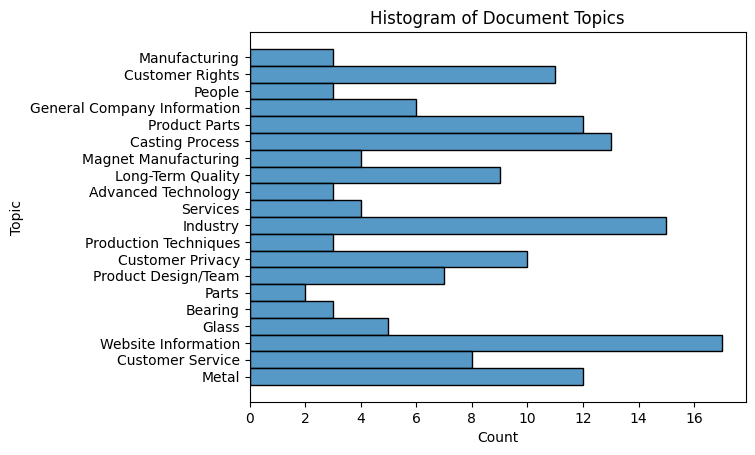

In [3]:
company_topics = pd.read_csv('./visualization_data/company_topics.csv', index_col='company_id')

ax = sns.histplot(data = company_topics, y='Overall_Topic')
ax.set(ylabel='Topic', title="Histogram of Document Topics");

From this output, it is clear that there are a number of focuses of companies on their websites in this industry. The most popular topics on these websites are website information, industry, the casting process, and product parts. This makes sense as website information such as privacy and cookie policies and are necessary to include on websites, and also I would hope that these companies describe their products and the overall industry in some detail as well. I can also use this analysis to determine which companies are more customer focused if the customer privacy and customer service topics are more emphasized on their websites as opposed to information on their actual products. Throughout the analysis, I expect to see this dichotomy play out between customer/people-facing language and industry/product details.

#### PCA

This dichotomy is most emphasized in the PCA analysis. The strings and their values for the first Principle Component, PC0, are shown below. These strings will help analyze what meaning we can extract from PC0.

In [4]:
LOADINGS = pd.read_csv('./data/LOADINGS.csv', index_col='term_str')
LOADINGS.sort_values('PC0', ascending=False)[:10]['PC0']

term_str
cookies      0.306787
data         0.116660
com          0.105064
privacy      0.103484
website      0.097390
web          0.095456
site         0.093309
rings        0.085628
bearing      0.082892
aerospace    0.077151
Name: PC0, dtype: float64

From the above terms, it is clear that these are mostly website, data, or privacy related. This indicates that companies that score high on PC0 likely value customer privacy, and have a large digital presence as their websites are built in a manner that contains information about cookies and privacy. PC1's most common words are shown below.

In [5]:
LOADINGS.sort_values('PC1', ascending=False)[:10]['PC1']

term_str
foundry      0.352463
bronze       0.322564
brass        0.271343
sand         0.172548
castings     0.129307
pattern      0.106895
art          0.102535
copper       0.083612
co           0.078572
aluminium    0.076305
Name: PC1, dtype: float64

From these words, it is clear that this Principle Component refers more to actual products or even raw materials, as we see bronze, brass, sand, copper, and aluminum in the top 10 words. These are more along the lines of raw materials that are converted to products, so it is likely that companies with a high value for this PC describe more about the process of creating their products. It can also be the case that these companies produce products that are closer to the raw materials, for example they may produce something further down in the supply chain like a magnet as opposed to something farther along like a plane.

We can also see where companies fall along this spectrum of customer care/website activity compared to raw material descriptions and production on their websites. Companies with higher PC0 values likely have larger websites and larger companies, though this would need to be confirmed with further research beyond the scope of this project as these companies are anonymized here.

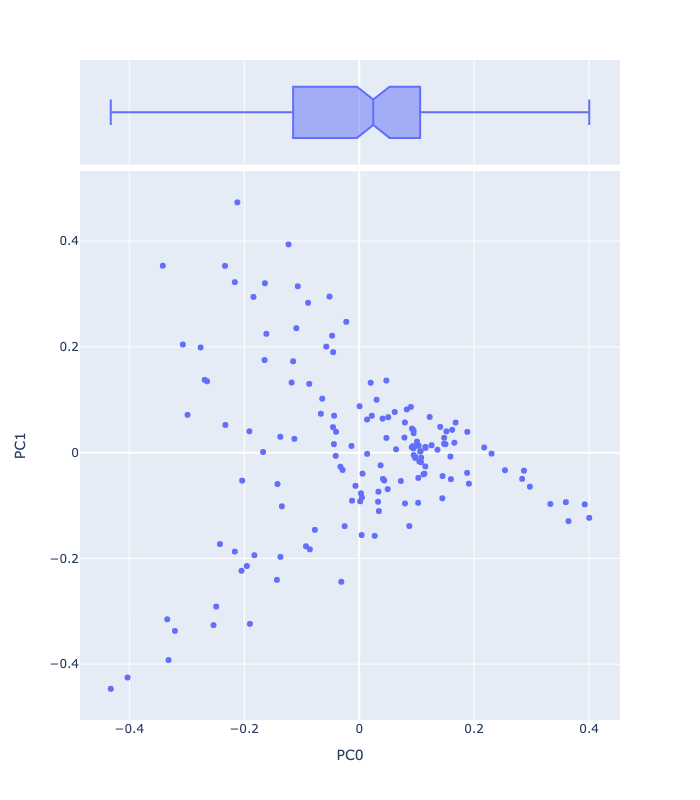

In [6]:
DCM = pd.read_csv('./data/DCM.csv', index_col='company_id')

fig = px.scatter(DCM.reset_index(), f"PC0", f"PC1", hover_name='company_id', 
                     symbol=None, size=None,
                     marginal_x='box', height=800)
fig.show('png')

From this, it is clear that there are a small number of companies that have high values for PC0 which is related to website and privacy information. There also seems to be an interesting downward trend, in that as companies become more digitally active and their websites contain more information about privacy policies, and cookies, they have less information about raw materials and products. This may indicate that as companies get further up the supply chain, they have more active digital presences, which would make sense. A company that gathers aluminum at the bottom of the supply chain would likely not need a big digital presence, but a company that is more consumer focused would need that larger digital presence to actually capture those consumers.

As for actual word breakdowns, PCA, KDE Word Correlations, and Word2vec are great ways to see how words relate to each other and the actual diction makeup of this corpus. First, I will examine PCA. PCA provides a breakdown of words by their PC's, which can help us determine which words relate more to the website/privacy area compared to the raw materials and product side.

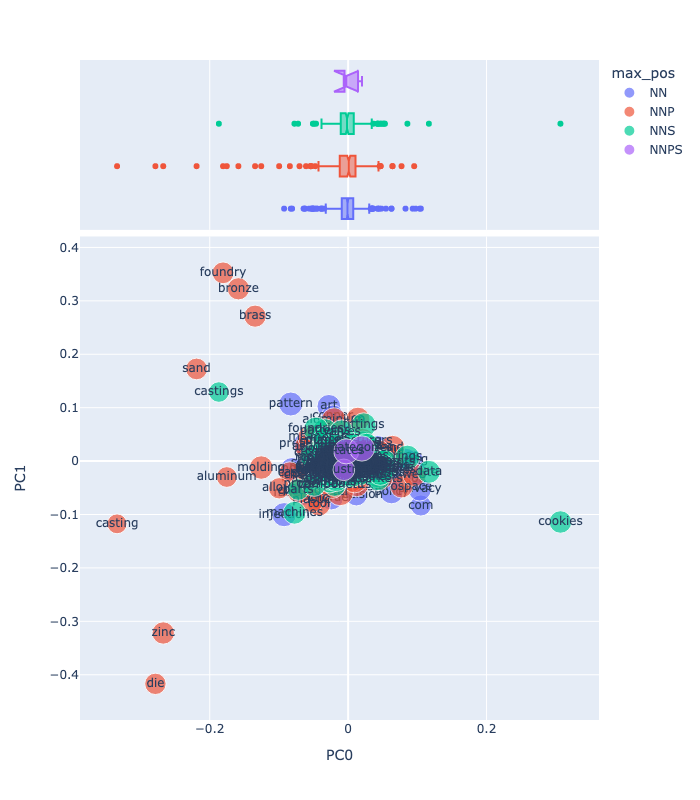

In [7]:
X = pd.read_csv('./visualization_data/X.csv')
fig = px.scatter(X.reset_index(), f"PC0", f"PC1", 
                      text='term_str', size='i', color='max_pos',
                      marginal_x='box', height=800)
fig.show('png')

The plot above shows some interesting trends about words that relate to the principal components. As you can see, for the website PC (PC), cookies is very far removed from other words, indicating that a website mentioning cookies is by far the best indicator of whether a company highlights website privacy. This makes sense, as other words such as data and privacy can be used in a non-website context as well, but cookies only makes sense in a website context. Also interesting is that for PC1, while I assigned a label of raw materials and products to this component, there are some other results that help refine this label. For example, zinc, which can be a raw material, scores low on PC1, and aluminum is about 0 while aluminium is one of the most closely associated words with PC1. This would indicate that there is something more specific than raw materials for products at play here and that certain materials are surprisingly not included as highly associated words with this PC.

#### Correlation KDE

Correlation Kernel Density Estimate plots provide a great way to examine how words relate to each other across the companies. Unfortunately, while most KDE's have a time component, there is no time component here. The x axis does not represent across time but rather different companies, so takeaways are more from comparing vertical values than across horizontal values. Below, I have plotted the KDE of multiple different raw materials to see how they relate to each other across company websites.

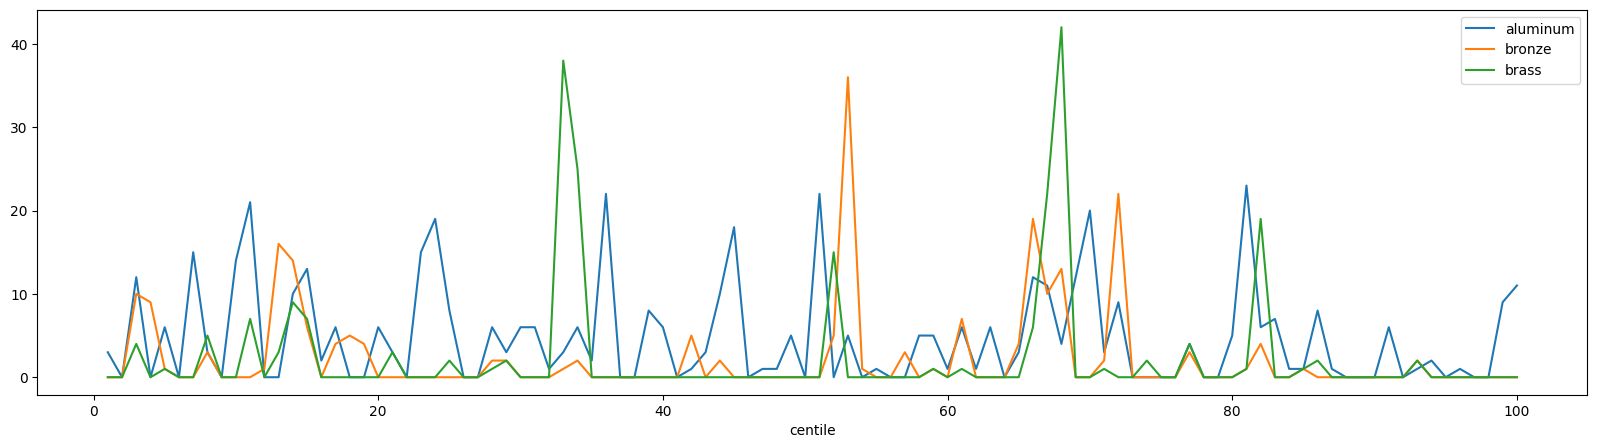

In [8]:
M = pd.read_csv('./visualization_data/M.csv', index_col='centile')
M[['aluminum', 'bronze', 'brass']].plot(figsize=(20,5), style='-');

From the plot above, we can see that the most common raw material across the companies is aluminum, though some of the websites heavily focus on bronze and brass while aluminum seems to be a common connecting theme. In addition, while I expected that when one of the raw materials is mentioned, the others are not mentioned as much, this trend does not seem to be followed in this graph. Other plots below attempt to examine the people vs. product differences in these websites.

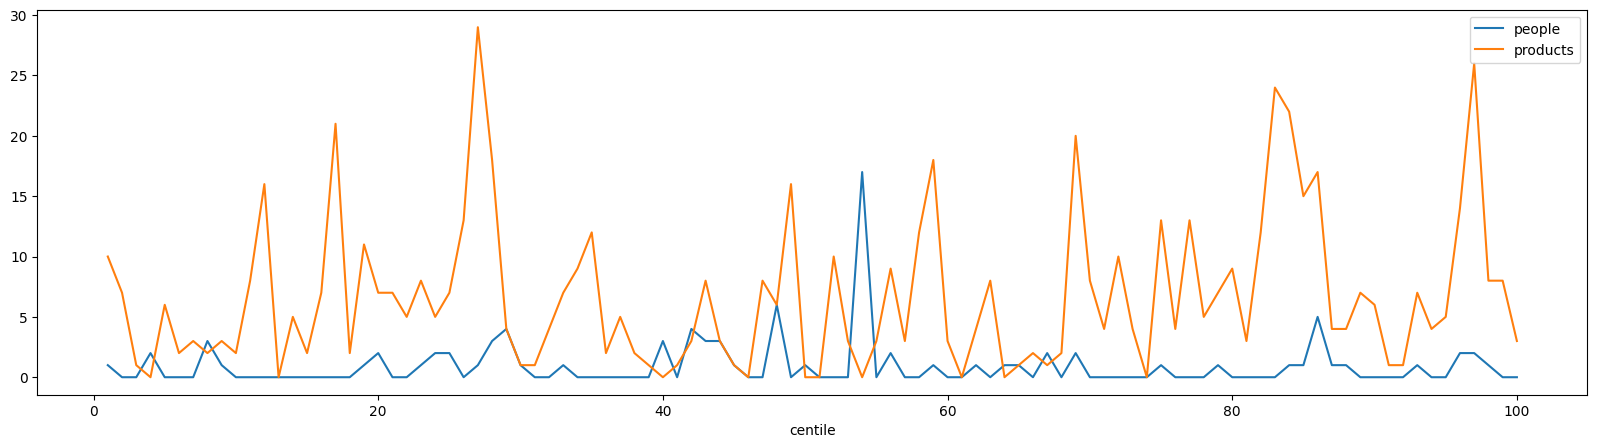

In [9]:
M[['people', 'products']].plot(figsize=(20,5), style='-');

From this plot, it is clear that products lead the way in terms of the people vs. product dichotomy between the companies. That makes sense, as most of these websites are not for companies that are pitching directly to a consumer, but rather they must show their product and the benefit of their product. These are usually not people-focused companies and that is clear from this plot.

#### Word2Vec

Those KDE's are useful when comparing a couple of words, but Word2Vec models will allow a comparison across vector space for all the words in the corpus, which is extremely helpful in determining what context words are used in for this corpus. The plot below shows the tSNE word relativity, where words that are close together have similar contexts and are similar in vector space according to this Rowling Word2Vec model.

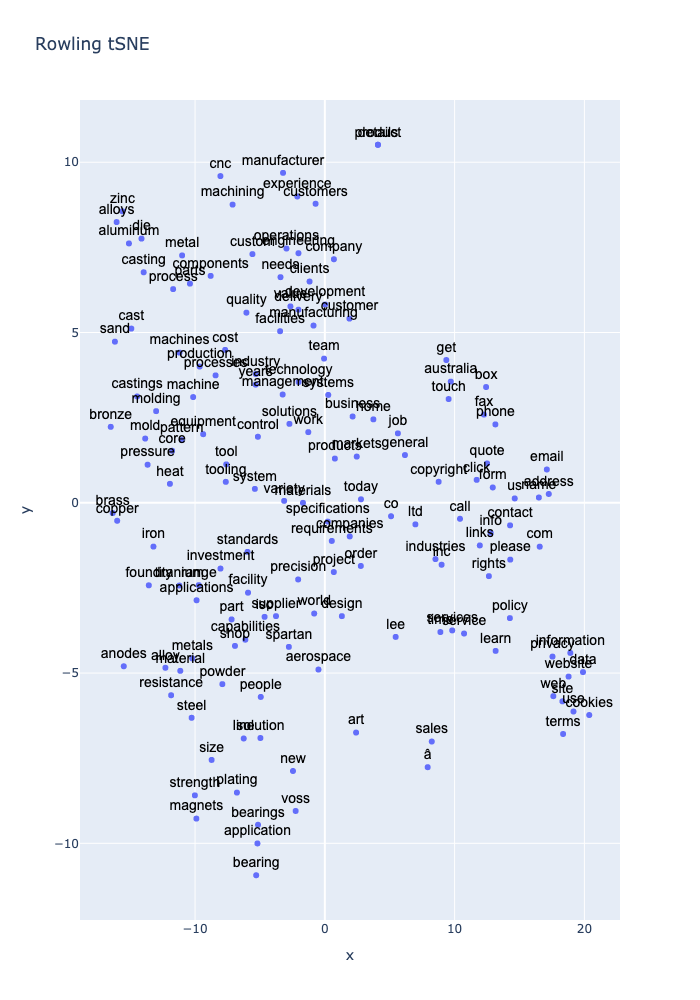

In [10]:
VOCAB_tsne = pd.read_csv('./data/VOCAB_tsne.csv', index_col='term_str')
fig = px.scatter(VOCAB_tsne.reset_index(), 'x', 'y', title = 'Rowling tSNE',
           text='term_str',  
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')
fig.show('png')

This Word2Vec tSNE plot is one of the most important and valuable plots in my report. For example, there is the clear website cluster of words that are related to privacy and website information such as terms, cookies, website, data, privacy, and information on the right side of the plot. Also, confirming my earlier suspicions, the different raw materials are related to various other words, and sometimes seem to be very different. For example, brass and copper are used in almost identical ways, which makes sense as these words are almost replacements for each other in terms of meaning and use. Furthermore, zinc, which we saw bucking the common trend in PC1 of raw materials, does seem to be more related to castings and alloys, as opposed to pure raw materials like bronze and others. Phone and fax are also close to each other, furthermore proving that the model worked well. Here is a useful simile to show further how words are related in this specific corpus, which is very unique in its context and word makeup.

In [11]:
rowling_model = Word2Vec.load('./visualization_data/rowling_model.model')

def complete_analogy(A, B, C, model, n=2):
    cols = ['term', 'sim']
    return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)

complete_analogy('metal', 'machines', 'cookies', rowling_model, 5)

,term,sim
0,use,0.991016
1,site,0.989835
2,information,0.987346
3,website,0.987052
4,web,0.986639


For context, the simile is metal is to machines as cookies is to blank, where the model fills in the blank. In this case, metal is used to make up machines and also can be what machines produce. Overall, the trend should capture that it is part of the whole. We see that the model here captures that cookies are part of use and also part of sites and information, all of which are totally true. This helps inform us of the ways that cookies are used contextually in the websites, as a part of both use of the user on the website, as well as the website itself.

#### Sentiment

While sentiment analysis for company website text may not be the most logical or helpful analytical process, there are still a couple of interesting takeaways from the analysis, especially when comparing across emotion space. For example, here are the top 10 companies for anger:

In [12]:
EMO_COMPANIES = pd.read_csv('./data/Company_emotions.csv', index_col='company_id')
EMO_COMPANIES.sort_values('anger', ascending=False)[:10]

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity
company_id,,,,,,,,,
858,0.402851,0.000000,0.402851,0.402851,0.000000,0.402851,0.000000,0.000000,-0.402851
187,0.283326,0.056735,0.000000,0.000000,0.000000,0.014771,0.000000,0.068082,-0.230015
392,0.283162,0.302301,0.000000,0.000000,0.000000,0.000000,0.016495,0.020585,-0.259932
902,0.216675,0.058520,0.062502,0.216675,0.000000,0.062502,0.000000,0.025371,-0.132785
503,0.196754,0.023183,0.000000,0.000000,0.015270,0.000000,0.002760,0.014855,-0.146206
661,0.164776,0.112451,0.083393,0.064897,0.059801,0.047677,0.036963,0.139868,-0.147470
218,0.130565,0.005569,0.000000,0.000000,0.000000,0.000000,0.000000,0.131943,0.006947
318,0.104569,0.111658,0.013839,0.060283,0.024135,0.049986,0.024135,0.075956,-0.068302
1047,0.089289,0.025158,0.000000,0.089289,0.000000,0.051812,0.089289,0.033493,-0.123110


The important takeaways here are that companies with high anger values also have negative polarity. Interestingly, while all the other emotions don't seem to be that associated with anger, trust does seem to have a significant connection, as there is only one zero value in that column. This is interesting as anger does not seem to be very associated with trust. However, because the emotion words are not based on company websites which is significantly different than traditional text. So, there may be certain words like privacy and site that may be related to trust but are not dealing with trust in our situation.

In [13]:
EMO_COMPANIES.sort_values('joy', ascending=False)[:10]

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity
company_id,,,,,,,,,
221,0.000000,0.000000,0.000000,0.299818,0.299818,0.000000,0.000000,0.299818,0.299818
1201,0.000000,0.217609,0.000000,0.000000,0.217609,0.000000,0.217609,0.273940,0.273940
856,0.037934,0.169647,0.037934,0.077718,0.169647,0.000000,0.066966,0.066966,0.131713
704,0.040728,0.126529,0.000000,0.009388,0.157780,0.032687,0.064027,0.071979,0.148392
66,0.045335,0.053820,0.000000,0.116439,0.109376,0.116439,0.000000,0.116088,0.008134
872,0.042495,0.125439,0.000000,0.029042,0.106840,0.014521,0.083772,0.056188,0.078865
828,0.030471,0.065981,0.016119,0.040298,0.105362,0.017120,0.076452,0.106487,0.099882
797,0.063305,0.118516,0.000000,0.063305,0.102115,0.029956,0.108531,0.062174,0.038810
721,0.073544,0.013145,0.000000,0.028571,0.082145,0.028571,0.028571,0.080665,0.073840


For the top 10 joy words, we see a complete flip with polarity, but we also see the same trends with trust as before, which is an interesting result. As expected, though, we see that anger is not as associated with companies that have high joy, which makes sense.

# Interpretation

It is difficult to have important conclusions and takeaways due to both the nature of the data being scraped website text data and the anonymization of the companies. I cannot provide any meaningful insights into specific companies and how they differ from others. However, I can provide insights gained on this industry and about the anonymized companies. There are a number of different dichotomies in industry that I explore in my analysis. 

The first important dichotomy is between people and products. Many companies struggle to find a balance on their websites between the people they hope to serve and the products they hope to sell. In some cases, companies pay lip service on their website to guarantee quality of their products, and mention that the people are the focus of their products. Other times, they aim to just provide an objective rundown of their products. The analysis in the previous section, specifically the KDE graph, shows that, at least in the magnetics industry, companies focus heavily on their products and less on people. This is likely because their products are very removed from people. Often, these companies are far down in the supply chain and they are selling to other suppliers, so rather than convince a consumer to purchase, they are describing their products and hoping it aligns with the needs of a supplier upstream.

Another important takeaway from this analysis is the dichotomy between website privacy information and product information on these companies's websites. This can be clearly seen in the LDA, PCA, and even the word embeddings as well. Some of these companies describe their cookie and website privacy policies in detail on their websites. It was clear from the graph of PC0 and PC1 that, as companies describe privacy policies more, they have less information about the actual products and materials they sell. This makes sense, as these are likely larger companies that may be more upstream in the supply chain who hope to make a good impression on their buyer, as opposed to smaller downstream companies who hope to advertise their product clearly and sell to interested parties. The stark difference between these two website representations is shown in the Word2Vec tSNE graph, where the terms website, policy, and privacy are very far from common product terms like machine, technology, product, and metal.

While working with this specific kind of anonymized, unstructured text data is difficult, it can be beneficial in understanding the industry. Furthermore, my results may be used as recommendations to new or struggling companies in the space. If you are a larger company with an active digital presence, be sure to include more detail on the actual products you are selling. If you are a smaller company, while you probably have that detail and objectivity built into your websites already, consumers also do like to see a care placed on website privacy, so attempt to include information about how you use their user information and what you website privacy policy is.